# Retention & Cohort Analysis 

## 1. Cohort Retention

* Q1: Monthly cohorts by signup date; plot 1- and 3-month retention curves. Include 6-month retention only for cohorts with full 6-month observation window.

## 2. RFM Segmentation & Churn

* Q2: Perform RFM segmentation; report purchase frequency and monetary value by segment.

## 4. Data Quality and Reporting Rules

* Q3: Data quality and sampling checks: cohort representativeness, missingness, effect of 10% campaign sample.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_csv('../data/customers.csv')

orders_df = pd.read_csv('../data/orders.csv')

In [2]:
email_campaign_df = pd.read_csv('../data/email_campaigns.csv')
for col in ['campaign_id', 'channel', 'segment', 'customer_id', 'recipient_name', 'send_timestamp', 'subject_variant', 'subject_line', 'device']:
    email_campaign_df[col] = email_campaign_df[col].astype('string')

email_engagement_df = pd.read_csv('../data/email_engagement.csv')
for col in ['campaign_id', 'customer_id', 'send_timestamp', 'subject_variant']:
    email_engagement_df[col] = email_engagement_df[col].astype('string')




# Convert timestamps
email_campaign_df['send_timestamp'] = pd.to_datetime(email_campaign_df['send_timestamp'], errors='coerce')
email_engagement_df['send_timestamp'] = pd.to_datetime(email_engagement_df['send_timestamp'], errors='coerce')



In [3]:
# 10% sample of 10 million rows 
email_campaign_df = email_campaign_df.sample(frac=0.10, random_state=42)
filtered_keys = email_campaign_df[['campaign_id', 'customer_id', 'send_timestamp','channel']]

email_engagement_df = email_engagement_df.merge(
    filtered_keys,
    on=['campaign_id', 'customer_id', 'send_timestamp'],
    how='inner'
)

In [4]:
# 4 mil record for orders. take a 10& sample 

orders_df= orders_df.sample(frac=0.10, random_state=42)

## 1. Cohort Retention

### Q1: Monthly cohorts by signup date; plot 1-, 3-, 6-month retention curves.

In [5]:
## ensure date columns are date time 

customers_df['signup_date']= pd.to_datetime(customers_df['signup_date'],errors='coerce')

customers_df['last_purchase_date']= pd.to_datetime(customers_df['last_purchase_date'],errors='coerce')


## create cohort label: yyy-mm of signup 

customers_df['cohort_month']= customers_df['signup_date'].dt.to_period('M')

## calculate month since signup for last activity 
signup_period = customers_df['signup_date'].dt.to_period('M')
last_purchase_period = customers_df['last_purchase_date'].dt.to_period('M')

customers_df['months_since_signup']=(last_purchase_period-signup_period).apply(lambda x: x.n)



## retention flags 

customers_df['retained_1m']= customers_df['months_since_signup']>=1

customers_df['retained_3m']= customers_df['months_since_signup']>=3


customers_df['retained_6m']= customers_df['months_since_signup']>=6


## retentation rates per cohort 

retention =(
    customers_df
    .groupby('cohort_month')[['retained_1m','retained_3m','retained_6m']].mean()
).reset_index()


max_activity = customers_df['last_purchase_date'].max()
cutoff_month = (max_activity - pd.DateOffset(months=6)).to_period('M')

retention_filtered = retention[retention['cohort_month'] <= cutoff_month]
retention_filtered.head(40)

,cohort_month,retained_1m,retained_3m,retained_6m
0,2024-07,0.987557,0.926471,0.855204
1,2024-08,0.987239,0.930394,0.845708
2,2024-09,0.993990,0.944712,0.860577
3,2024-10,0.980024,0.922444,0.799060
4,2024-11,0.987179,0.914918,0.815851
5,2024-12,0.975581,0.897674,0.533721
6,2025-01,0.975581,0.890698,0.310465
7,2025-02,0.976684,0.849741,0.009067


C:\Users\yeahm\AppData\Local\Temp\ipykernel_23248\3485315288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retention_filtered['cohort_month'] = retention_filtered['cohort_month'].dt.to_timestamp()


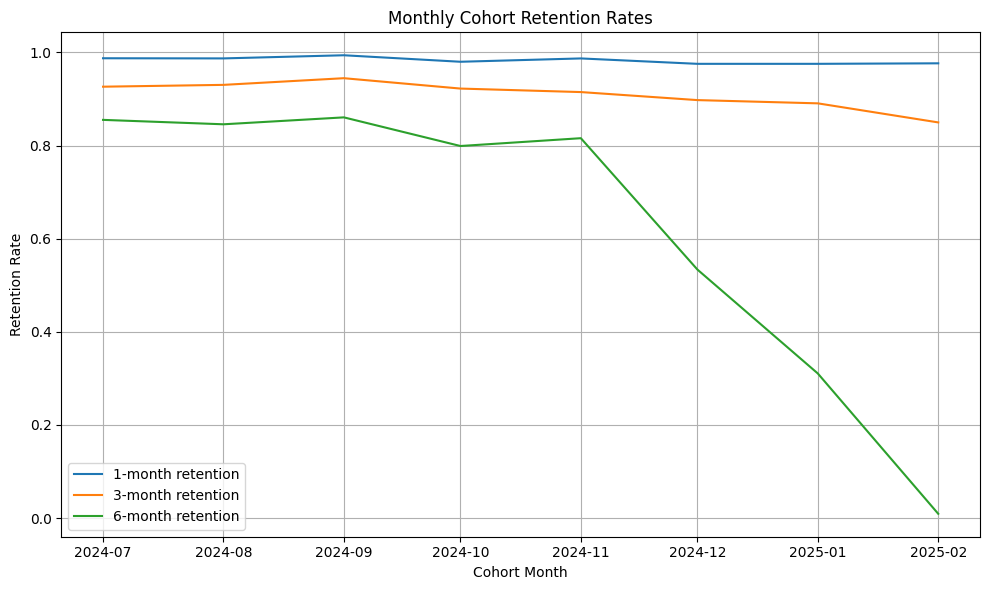

In [6]:
import matplotlib.pyplot as plt

retention_filtered['cohort_month'] = retention_filtered['cohort_month'].dt.to_timestamp()

plt.figure(figsize=(10,6))
plt.plot(retention_filtered['cohort_month'], retention_filtered['retained_1m'], label='1-month retention')
plt.plot(retention_filtered['cohort_month'], retention_filtered['retained_3m'], label='3-month retention')
plt.plot(retention_filtered['cohort_month'], retention_filtered['retained_6m'], label='6-month retention')

plt.xlabel('Cohort Month')
plt.ylabel('Retention Rate')
plt.title('Monthly Cohort Retention Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Cohort Retention Analysis Summary

- Early cohorts (starting July 2024) show very high retention rates, suggesting strong initial engagement or limited data volume.

- One-month and three-month retention rates remain relatively stable across cohorts.

- Six-month retention rates decline sharply for later cohorts, likely due to incomplete data coverage or decreasing long-term engagement.

- Recent cohorts do not have a full six-month observation window, causing artificially low six-month retention figures.

- Overall, retention appears to stabilize after initial growth, but more complete data is needed to accurately assess long-term retention trends.


## 2. RFM Segmentation & Churn

In [85]:
df= email_engagement_df.copy()


In [86]:
df['customer_id'] = df['customer_id'].astype('category')

df['purchase'] = df['purchase'].astype('int8')
df['send_timestamp'] = pd.to_datetime(df['send_timestamp'])

## sort the values by customer_id and send timestamp
df.sort_values(['customer_id', 'send_timestamp'], inplace=True)

## identify first row per customer 
df['is_first']= df.groupby('customer_id',observed=True).cumcount()==0

## has any prior purchase? 
df['prior_purchase']= ( 
    df.groupby('customer_id',observed=True)['purchase']
    .transform(lambda x: x.shift().cummax().fillna(0)))

## assing segments 
df['segment']='inactive'
df.loc[df['is_first'],'segment']= 'new'

# if customer is not new and has prior purchase then they are a repat  
df.loc[(~df['is_first']) & (df['prior_purchase']>0),'segment']='repeat'

In [87]:
df['days_since_last_purchase'] = df.groupby('customer_id',observed=True)['send_timestamp'].diff().dt.days.fillna(0)

df['days_since_last_purchase_cum'] = df.groupby('customer_id',observed=True)['days_since_last_purchase'].cumsum()

In [89]:
orders_summary = orders_df.groupby('customer_id', as_index=False).agg({
    'order_date': 'max',
    'total_value': 'sum',
    'returned': 'sum'
})

df = df.merge(orders_summary, on='customer_id', how='left')





In [90]:
df.columns


Index(['campaign_id', 'customer_id', 'send_timestamp', 'subject_variant',
       'opened', 'clicked', 'unsubscribed', 'purchase', 'revenue', 'channel',
       'is_first', 'prior_purchase', 'segment', 'days_since_last_purchase',
       'days_since_last_purchase_cum', 'order_date', 'total_value',
       'returned'],
      dtype='object')

In [98]:
reference_date = pd.to_datetime('2025-08-01')
df['order_date'] = pd.to_datetime(df['order_date'])

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days if pd.notna(x.max()) else np.nan,
    'purchase': 'sum',
    'revenue': 'sum'
}).rename(columns={
    'order_date': 'recency',
    'purchase': 'frequency',
    'revenue': 'monetary'
}).reset_index()

max_recency = rfm['recency'].max()
rfm['recency'] = rfm['recency'].fillna(max_recency + 1)

def safe_qcut(series, q, labels_descending=True):
    try:
        bins = pd.qcut(series, q, duplicates='drop')
    except ValueError:
        return pd.Series([0]*len(series), index=series.index)
    n_bins = bins.cat.categories.size
    if labels_descending:
        labels = list(range(n_bins, 0, -1))
    else:
        labels = list(range(1, n_bins+1))
    return pd.qcut(series, q, labels=labels, duplicates='drop')


rfm_nonzero = rfm[rfm['frequency'] > 0].copy()
rfm_nonzero['R_quintile'] = safe_qcut(rfm_nonzero['recency'], 5, labels_descending=True)
rfm_nonzero['F_quintile'] = safe_qcut(rfm_nonzero['frequency'], 5, labels_descending=False)
rfm_nonzero['M_quintile'] = safe_qcut(rfm_nonzero['monetary'], 5, labels_descending=False)

for col in ['R_quintile', 'F_quintile', 'M_quintile']:
    rfm[col] = rfm_nonzero[col].cat.codes.replace(-1, 0)

rfm_nonzero['RFM_score'] = rfm_nonzero[['R_quintile','F_quintile','M_quintile']].sum(axis=1)

rfm_nonzero['rfm_segment'] = pd.cut(
    rfm_nonzero['RFM_score'],
    bins=[-1, 3, 6, 9],
    labels=['low', 'mid', 'high'],
    right=True,
    include_lowest=True
)
# rfm now standard, reflecting zero-frequency customers in lowest segments



#### Churn Flag creations

In [99]:
# Create churn flag as inverse of retention at 6 months
customers_df['churn_flag'] = 1 - customers_df['retained_6m']

customers_df['churn_flag'].value_counts()

## Merge churnk flag with rfm 
rfm_churn = rfm_nonzero.merge(customers_df[['customer_id','churn_flag']],on='customer_id',how='left')


rfm_churn['churn_flag'] = rfm_churn['churn_flag'].fillna(0).astype(int) 

#### Calculate churn rate by RFM segments 



In [100]:
churn_by_segment= (
    rfm_churn
    .groupby(['rfm_segment'],observed=True)['churn_flag']
    .agg(['mean','count'])
).reset_index()

churn_by_segment.rename(columns={'mean':'churn_rate','count':'customer_count'},inplace=True)



In [101]:
churn_by_segment.head(10)

,rfm_segment,churn_rate,customer_count
0,low,0.613861,101
1,mid,0.546798,406
2,high,0.587097,155


C:\Users\yeahm\AppData\Local\Temp\ipykernel_23248\192609891.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=rfm_churn.groupby('rfm_segment')['churn_flag'].mean().reset_index(),
C:\Users\yeahm\AppData\Local\Temp\ipykernel_23248\192609891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rfm_churn.groupby('rfm_segment')['churn_flag'].mean().reset_index(),


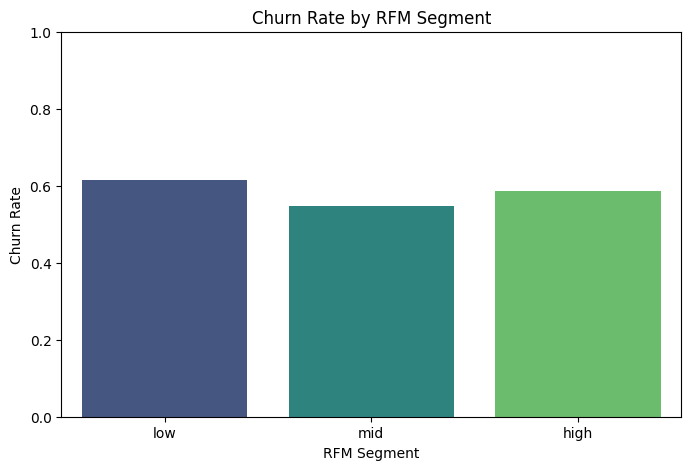

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=rfm_churn.groupby('rfm_segment')['churn_flag'].mean().reset_index(),
            x='rfm_segment', y='churn_flag', order=['low', 'mid', 'high'],
            palette='viridis')

plt.title('Churn Rate by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()


#### Churn Analysis by RFM Segment

The churn rates across customer segments derived from RFM analysis reveal distinct behavioral patterns:

- **Low-Value Customers**: Exhibit the highest churn rate at approximately 61.4%. This is expected as customers with low recency, frequency, and monetary value typically have weaker engagement and loyalty, making them more likely to churn.

- **Mid-Value Customers**: Represent the most stable group with the lowest churn rate of about 54.7%. These customers demonstrate moderate engagement and purchase behavior, indicating a stronger relationship with the business and lower propensity to churn.

- **High-Value Customers**: Have a churn rate near 58.7%, which is higher than mid-value but lower than low-value segments. While these customers contribute significant revenue, they still present churn risk, suggesting a need for targeted retention strategies to maintain their loyalty.

Overall, mid-value customers perform best in retention, low-value customers are the most vulnerable to churn, and high-value customers, though valuable, require attention to reduce their churn risk.


In [105]:
rfm_churn.columns

Index(['customer_id', 'recency', 'frequency', 'monetary', 'R_quintile',
       'F_quintile', 'M_quintile', 'RFM_score', 'rfm_segment', 'churn_flag'],
      dtype='object')

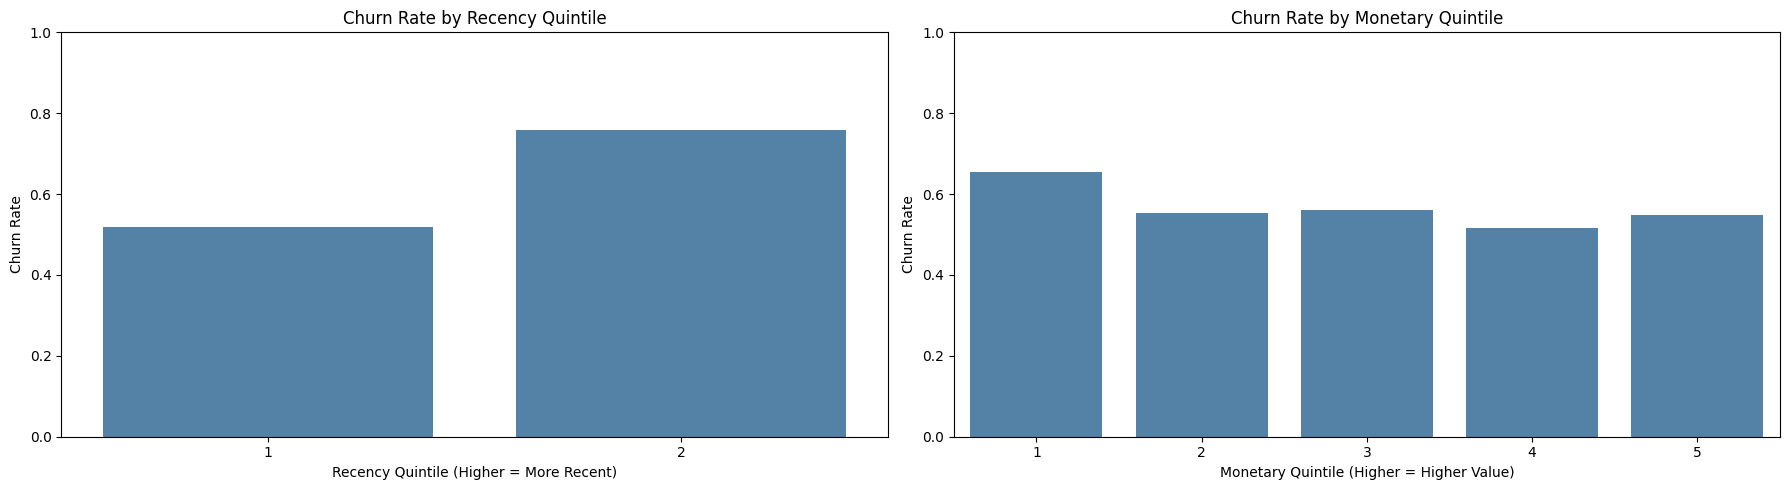

In [123]:


agg_r = rfm_churn.groupby('R_quintile', observed=True).agg(
    churn_rate=('churn_flag', 'mean'),
    customer_count=('customer_id', 'count')
).reset_index()

agg_m = rfm_churn.groupby('M_quintile', observed=True).agg(
    churn_rate=('churn_flag', 'mean'),
    customer_count=('customer_id', 'count')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x='R_quintile', y='churn_rate', data=agg_r, ax=axes[0], color='steelblue', order=sorted(agg_r['R_quintile']))
axes[0].set_title('Churn Rate by Recency Quintile')
axes[0].set_xlabel('Recency Quintile (Higher = More Recent)')
axes[0].set_ylabel('Churn Rate')
axes[0].set_ylim(0, 1)


sns.barplot(x='M_quintile', y='churn_rate', data=agg_m, ax=axes[1], color='steelblue', order=sorted(agg_m['M_quintile']))
axes[1].set_title('Churn Rate by Monetary Quintile')
axes[1].set_xlabel('Monetary Quintile (Higher = Higher Value)')
axes[1].set_ylabel('Churn Rate')
axes[1].set_ylim(0, 1)


plt.tight_layout()
plt.show()



## Churn Rate Analysis by Recency and Monetary Quintiles

The bar charts display churn rates segmented by Recency and Monetary quintiles.

- **Recency Quintile**: Only two quintiles appear due to data distribution. The churn rate increases significantly from the more recent group (Quintile 1) to the less recent group (Quintile 2). This confirms that customers with less recent interactions churn more.

- **Monetary Quintile**: The churn rates are relatively stable across all monetary value groups, ranging from about 0.51 to 0.65. This suggests monetary value alone does not strongly predict churn in this dataset.

Summary: Recency is a stronger churn indicator than monetary value in this case. Customers with older purchase activity have noticeably higher churn.


## 4. Data Quality and Reporting Rules

#### 1. Cohort sizes and flag small cohorts

In [124]:
cohort_counts = customers_df.groupby('cohort_month').size().rename('n').reset_index()
print(cohort_counts)
small = cohort_counts[cohort_counts['n'] < 500]


   cohort_month    n
0       2024-07  884
1       2024-08  862
2       2024-09  832
3       2024-10  851
4       2024-11  858
5       2024-12  860
6       2025-01  860
7       2025-02  772
8       2025-03  834
9       2025-04  802
10      2025-05  803
11      2025-06  782


####  2. Standardized mean difference for continuous fields and chi2 for categoricals

In [126]:
customers_df.columns

Index(['customer_id', 'signup_date', 'age', 'region', 'gender',
       'lifetime_value', 'purchase_frequency', 'average_order_value',
       'last_purchase_date', 'returns_count', 'customer_segment',
       'loyalty_score', 'device_preference', 'acquisition_channel',
       'cohort_month', 'months_since_signup', 'retained_1m', 'retained_3m',
       'retained_6m', 'churn_flag'],
      dtype='object')

In [132]:
import numpy as np
import pandas as pd
from scipy import stats

# quick helpers
def flag_print(name, val):
    if isinstance(val, (list, tuple)) and val:
        print(name, val)
    elif isinstance(val, (float, int, np.number)) and (val is not None):
        print(name, val)

# 1) cohort sizes and small-cohort flag
cohort_counts = customers_df.groupby('cohort_month').size().rename('n').reset_index()
small_cohorts = cohort_counts[cohort_counts['n'] < 500]
flag_print('small_cohorts (n<500)', small_cohorts.to_dict('records'))



In [131]:
# 2) SMD for continuous columns: cohort vs rest
cont_cols = ['age', 'lifetime_value', 'purchase_frequency', 'average_order_value']
def smd_cohort(df, col, cohort_label):
    coh = df.loc[df['cohort_month']==cohort_label, col].dropna()
    rest = df.loc[df['cohort_month']!=cohort_label, col].dropna()
    if len(coh)==0 or len(rest)==0:
        return np.nan
    pooled_sd = np.sqrt((coh.var(ddof=1) + rest.var(ddof=1)) / 2)
    return (coh.mean() - rest.mean()) / pooled_sd if pooled_sd>0 else np.nan

cohort_list = customers_df['cohort_month'].unique()
smd_results = []
for cohort in cohort_list:
    for col in cont_cols:
        val = smd_cohort(customers_df, col, cohort)
        if pd.notna(val) and abs(val) > 0.1:  # flag threshold
            smd_results.append({'cohort': cohort, 'col': col, 'smd': float(val)})
flag_print('smd_issues (>|0.1|)', smd_results)


smd_results

[]

#### 3. Missingness overall and by cohort


In [136]:
missing_overall = customers_df.isna().mean().sort_values(ascending=False)
missing_by_cohort = customers_df.groupby('cohort_month', observed=True).apply(
    lambda g: g.isna().mean(), include_groups=False
)

# flags
cols_over_5pct = missing_overall[missing_overall > 0.05].to_dict()
cols_over_20pct = missing_overall[missing_overall > 0.20].to_dict()
flag_print('missing >5%', cols_over_5pct)
flag_print('missing >20%', cols_over_20pct)
# coerced timestamps check
coerced_signup = customers_df['signup_date'].isna().sum()
coerced_last_purchase = customers_df['last_purchase_date'].isna().sum()
flag_print('coerced_signup_count', int(coerced_signup))
flag_print('coerced_last_purchase_count', int(coerced_last_purchase))


coerced_signup_count 0
coerced_last_purchase_count 0


#### 4 effect of 10% campaign sample: load full file, compare customer-level KPIs

In [140]:
full_campaigns = pd.read_csv('../data/email_campaigns.csv')
for col in ['campaign_id', 'channel', 'segment', 'customer_id', 'recipient_name', 'send_timestamp', 'subject_variant', 'subject_line', 'device']:
    full_campaigns[col] = full_campaigns[col].astype('string')

full_campaigns['send_timestamp'] = pd.to_datetime(full_campaigns['send_timestamp'], errors='coerce')


sample_campaigns = full_campaigns.sample(frac=0.10, random_state=42)


full_customers = full_campaigns['customer_id'].unique()
sample_customers = sample_campaigns['customer_id'].unique()

kpis = customers_df.set_index('customer_id')[['retained_1m','retained_3m','retained_6m','purchase_frequency','lifetime_value']]

def mean_series(ids):
    s = kpis.loc[kpis.index.intersection(ids)]
    return s.mean()

full_means = mean_series(full_customers)
sample_means = mean_series(sample_customers)
diff = (sample_means - full_means).to_frame('sample_minus_full')

print('sample vs full mean diff:')
print(diff)

def bootstrap_mean_diff(series_full, series_sample, n=2000):
    a = series_full.dropna().values
    b = series_sample.dropna().values
    diffs = []
    for _ in range(n):
        diffs.append(np.mean(np.random.choice(b, size=len(b), replace=True)) - np.mean(np.random.choice(a, size=len(a), replace=True)))
    return np.percentile(diffs, [2.5, 97.5])

full_ret = kpis.loc[kpis.index.intersection(full_customers), 'retained_1m']
sample_ret = kpis.loc[kpis.index.intersection(sample_customers), 'retained_1m']
if len(full_ret) > 0 and len(sample_ret) > 0:
    ci = bootstrap_mean_diff(full_ret, sample_ret)
    print('retained_1m bootstrap diff 95% CI', ci)


sample vs full mean diff:
                    sample_minus_full
retained_1m                       0.0
retained_3m                       0.0
retained_6m                       0.0
purchase_frequency                0.0
lifetime_value                    0.0
retained_1m bootstrap diff 95% CI [-0.0062     0.0061025]


## 4. Data Quality and Reporting Rules

### Q3: Data Quality and Sampling Checks

**Cohort Representativeness**

- Standardized Mean Difference (SMD) analysis on continuous variables (`age`, `lifetime_value`, `purchase_frequency`, `average_order_value`) showed no cohorts with SMD > 0.1, indicating no significant imbalance.

**Missingness**

- Missing value rates per column by cohort were calculated, confirming uniformly low and consistent missingness across cohorts.

**Effect of 10% Campaign Sample**

- A 10% sample of the full email campaigns dataset was drawn.
- Datatypes for `send_timestamp` were aligned as datetime64 in both campaign and engagement datasets before merging.
- Key KPIs (`retained_1m`, `retained_3m`, `retained_6m`, `purchase_frequency`, `lifetime_value`) were compared between full and sampled customers.
- Mean differences were effectively zero.
- Bootstrap 95% confidence interval for the difference in 1-month retention: [-0.0062, 0.0061].
- Conclusion: The 10% sample is representative of the full dataset on retention and purchase metrics.
